In [331]:
import csv
from collections import defaultdict
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from scipy.optimize import curve_fit
import seaborn as sns
import ast

# Random Analysis 
Random gameplay serves as a control group. It provides a reference point against which the performance of other algorithms can be measured. This control helps ensure that observed differences in performance are due to the algorithms' strategies rather than random chance. 

### Random vs Random 
We are using random vs random to provide a baseline comparison to evaluate the performance of Minimax and Negamax. By comparing against random gameplay, we can assess whether the algorithm is performing better than random chance. 

### Strategy Evaluation 
By looking at the most common win directions and the number of turns to win, this can reveal patterns or tendencies in gameplay that might be exploited or improved upon

### Robustness Testing 
Testing against random opponents helps asses the robustness of the given algorithm. If the algorithm performs well agains random opponents, it suggests it can handle divers and unpredictable strategies effectively. 

Comparing against random opponents can highlight weaknesses in a given algorithm. For example, if said aglorithm consistently loses against random opponents, it may indicate areas for improvement such as better handling of unexpected moves. 

### Player vs Random 
Due to the circular nature connect four twist and turn as well as the new ways that connections can be made with the twist functionality, often winning moves can be overlooked by human players. 

In [332]:
# Filenames

# Random Benchmarking
random_vs_random = "Results/random_vs_random.csv"
minimax_vs_random = "Results/minimax_vs_random.csv"
negamax_vs_random = "Results/negamax_vs_random.csv"

# Greedy Benchmarking 
minimax_vs_greedy = "Results/minimax_vs_greedy.csv"

random_vs_random = "Results/random1_vs_random2.csv"

from tabulate import tabulate


In [333]:
# Define the new header row

def define_header_row(filename):

    new_header = ["winner","starter","total_turns","win_direction","ab_pruning","t_tables","depth","turn_times","average_turn_time","turn_nodes","average_turn_nodes"]
    


    # Read the existing data from the CSV file
    data = []
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        header = next(reader)  # Read the existing header
        for row in reader:
            data.append(row)

    # Write the new header and existing data back to the CSV file
    with open(random_vs_random, 'w', newline='') as file:
        writer = csv.writer(file)
        
        # Write the new header
        writer.writerow(new_header)
        
        # Write the existing data
        writer.writerows(data)


def preview_file(filename):
    # Display the updated CSV file
    fileContent = pd.read_csv(filename)
    print(fileContent)



def group_and_plot_by_depth_all_games(filename, plot_type):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(filename)
    
    # Print the DataFrame columns to check if the chosen plot type exists
    print("DataFrame columns:", df.columns)
    
    # Check if the chosen plot type column exists
    if plot_type in df.columns:
        df[plot_type] = df[plot_type].apply(lambda x: eval(x))
    else:
        print(f"'{plot_type}' column not found in the DataFrame.")
        return

    # Group by depth
    depth_groups = df.groupby('depth')

    for depth, group in depth_groups:
        plt.figure()
        for index, row in group.iterrows():
            data = row[plot_type]
            x_vals = []
            y_vals = []

            if row['starter'] == 'Minimax' or row['starter'] == 'Negamax':
                for i in range(len(data)):
                    x_vals.append(i * 2 + 1)  # Minimax's turns are 1, 3, 5, ...
                    y_vals.append(data[i])
            else:
                for i in range(len(data)):
                    x_vals.append(i * 2 + 2)  # Minimax's turns are 2, 4, 6, ...
                    y_vals.append(data[i])

            plt.plot(x_vals, y_vals, marker='o')

        plt.title(f'{plot_type.capitalize()} for Depth {depth}')
        plt.xlabel('Turn')
        plt.ylabel(f'{plot_type.capitalize()}')
        plt.legend()
        plt.show()




def group_and_plot_by_depth_cobf(filename, plot_type):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(filename)
    
    # Print the DataFrame columns to check if the chosen plot type exists
    print("DataFrame columns:", df.columns)
    
    # Check if the chosen plot type column exists
    if plot_type in df.columns:
        df[plot_type] = df[plot_type].apply(lambda x: eval(x))
    else:
        print(f"'{plot_type}' column not found in the DataFrame.")
        return

    # Group by depth
    depth_groups = df.groupby('depth')

    for depth, group in depth_groups:
        fig, ax = plt.subplots(figsize=(8, 6))  # Create a single subplot
        x_vals_all = []
        y_vals_all = []

        for index, row in group.iterrows():
            data = row[plot_type]
            x_vals = []
            y_vals = []

            if row['starter'] == 'Minimax' or row['starter'] == 'Negamax':
                for i in range(len(data)):
                    x_vals.append(i * 2 + 1)  # Minimax's turns are 1, 3, 5, ...
                    y_vals.append(data[i])
            else:
                for i in range(len(data)):
                    x_vals.append(i * 2 + 2)  # Minimax's turns are 2, 4, 6, ...
                    y_vals.append(data[i])

            x_vals_all.extend(x_vals)
            y_vals_all.extend(y_vals)

        # Fit polynomial regression model
        degree = 3  # Define degree of polynomial
        model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
        X = np.array(x_vals_all).reshape(-1, 1)
        model.fit(X, y_vals_all)
        y_pred = model.predict(X)

        # Plot the curve of best fit
        x_range = np.linspace(min(x_vals_all), max(x_vals_all), 100)
        y_range = model.predict(x_range.reshape(-1, 1))
        ax.plot(x_range, y_range, linestyle='--', color='red', label='Curve of Best Fit')

        # Plot individual game data
        ax.scatter(x_vals_all, y_vals_all, marker='o', label=f"{plot_type.capitalize()} Data")

        # Set titles and labels
        ax.set_title(f'Curve of Best Fit for Depth {depth}')
        ax.set_xlabel('Turn')
        ax.set_ylabel(f'{plot_type.capitalize()}')
        ax.legend()

        plt.tight_layout()  # Adjust layout to prevent overlapping
        plt.show()

def calculate_win_rates(filename, p1, p2):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(filename)
    
    # Convert the depth column to string to avoid confusion during grouping
    df['depth'] = df['depth'].astype(str)
    
    # Group by depth
    depth_groups = df.groupby('depth')
    
    win_rates = {}
    
    for depth, group in depth_groups:
        total_games = len(group)
        p1_wins = len(group[group['winner'] == p1])
        p2_wins = len(group[group['winner'] == p2])
        
        avg_nodes_per_turn = group['average_turn_nodes'].mean()
        avg_time_per_turn = group['average_turn_time'].mean()
        
        win_rates[depth] = {
            'total_games': total_games,
            f'{p1}_wins': p1_wins,
            f'{p2}_wins': p2_wins,
            f'{p1}_win_rate': p1_wins / total_games if total_games > 0 else 0,
            f'{p2}_win_rate': p2_wins / total_games if total_games > 0 else 0,
            'avg_nodes_per_turn': avg_nodes_per_turn,
            'avg_time_per_turn': avg_time_per_turn
        }
    
    return win_rates

def plot_win_rates(win_rates, p1, p2):
    depths = sorted(win_rates.keys(), key=lambda x: int(x))  # Sort depths numerically
    
    p1_win_rates = [win_rates[depth][f'{p1}_win_rate'] for depth in depths]
    p2_win_rates = [win_rates[depth][f'{p2}_win_rate'] for depth in depths]
    avg_nodes_per_turn = [win_rates[depth]['avg_nodes_per_turn'] for depth in depths]
    avg_time_per_turn = [win_rates[depth]['avg_time_per_turn'] for depth in depths]

    x = range(len(depths))

    bar_width = 0.35  # Width of the bars
    
    # Set the color palette
    palette = sns.color_palette("Paired", 6)
    
    fig, ax1 = plt.subplots(figsize=(12, 8))

    # Plot win rates
    ax1.bar(x, p2_win_rates, width=bar_width, label=f'{p2} Win Rate', color=palette[0], align='center')
    ax1.bar([i + bar_width for i in x], p1_win_rates, width=bar_width, label=f'{p1} Win Rate', color=palette[1], align='center')

    ax1.set_xlabel('Depth')
    ax1.set_ylabel('Win Rate')
    ax1.set_title('Win Rates by Depth')
    ax1.set_xticks([i + bar_width / 2 for i in x])
    ax1.set_xticklabels(depths)
    ax1.legend(loc='upper left')
    ax1.grid(True, axis='y')

    # Create another y-axis for average nodes per turn
    ax2 = ax1.twinx()
    ax2.plot([i + bar_width / 2 for i in x], avg_nodes_per_turn, label='Average Nodes per Turn', color=palette[2], marker='o')
    ax2.set_ylabel('Average Nodes per Turn', color=palette[2])
    ax2.tick_params(axis='y', labelcolor=palette[2])

    # Create a third y-axis for average time per turn
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))  # Offset the third y-axis
    ax3.plot([i + bar_width / 2 for i in x], avg_time_per_turn, label='Average Time per Turn', color=palette[3], marker='s')
    ax3.set_ylabel('Average Time per Turn (s)', color=palette[3])
    ax3.tick_params(axis='y', labelcolor=palette[3])

    fig.tight_layout()
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.show()

def format_data_as_table(data, p1, p2):
    # Prepare data for the DataFrame
    formatted_data = []
    for depth, metrics in data.items():
        row = {
            'Depth': depth,
            'Total Games': metrics['total_games'],
            f'{p1} Wins': metrics[f'{p1}_wins'],
            f'{p2} Wins': metrics[f'{p2}_wins'],
            f'{p1} Win Rate': metrics[f'{p1}_win_rate'],
            f'{p2} Win Rate': metrics[f'{p2}_win_rate'],
            'Avg Nodes per Turn': metrics['avg_nodes_per_turn'],
            'Avg Time per Turn': metrics['avg_time_per_turn']
        }
        formatted_data.append(row)
    
    # Create DataFrame
    df = pd.DataFrame(formatted_data)
    
    # Print the DataFrame in a nicely formatted table
    print(tabulate(df, headers='keys', tablefmt='simple_grid', showindex=False))


# Example usage:




# Random vs Random

In [349]:

def calculate_win_statistics_from_csv(filename):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(filename, names=['winner', 'starter', 'total_turns', 'win_direction', 'ab_pruning', 't_tables'])
    
    # Convert the 'total_turns' column to numeric, forcing any invalid parsing to NaN
    df['total_turns'] = pd.to_numeric(df['total_turns'], errors='coerce')
    
    # Drop rows with NaN values in 'total_turns'
    df = df.dropna(subset=['total_turns'])
    
    # Ensure 'total_turns' is of integer type after cleaning
    df['total_turns'] = df['total_turns'].astype(int)

    # Calculate total games
    total_games = len(df)

    # Calculate wins for Random1 and Random2
    random1_wins = len(df[df['winner'] == 'Random1'])
    random2_wins = len(df[df['winner'] == 'Random2'])

    # Calculate win rates
    random1_win_rate = random1_wins / total_games if total_games > 0 else 0
    random2_win_rate = random2_wins / total_games if total_games > 0 else 0

    # Calculate the number of wins for each win direction
    win_directions_count = df['win_direction'].value_counts().to_dict()

    # Calculate the average number of turns per game
    average_turns = df['total_turns'].mean()

    return {
        'Random1_win_rate': random1_win_rate,
        'Random2_win_rate': random2_win_rate,
        'Total_games': total_games,
        'Random1_wins': random1_wins,
        'Random2_wins': random2_wins,
        'Win_directions_count': win_directions_count,
        'Average_turns': average_turns
    }

# Example usage

statistics = calculate_win_statistics_from_csv(random_vs_random)

# Print results
print(f"Random1 Win Rate: {statistics['Random1_win_rate']:.2f}")
print(f"Random2 Win Rate: {statistics['Random2_win_rate']:.2f}")
print(f"Total Games: {statistics['Total_games']}")
print(f"Random1 Wins: {statistics['Random1_wins']}")
print(f"Random2 Wins: {statistics['Random2_wins']}")
print(f"Average Turns per Game: {statistics['Average_turns']:.2f}")
print("Win Directions Count:")
for direction, count in statistics['Win_directions_count'].items():
    print(f"  {direction}: {count}")



Random1 Win Rate: 0.53
Random2 Win Rate: 0.47
Total Games: 2115
Random1 Wins: 1112
Random2 Wins: 1003
Average Turns per Game: 15.95
Win Directions Count:
  horizontal: 812
  vertical: 635
  lru: 373
  lrd: 295


In [348]:
statistics = calculate_random_win_rates_from_csv(random_vs_random)
#print(win_rates)
print(f"Random1 Win Rate: {statistics['Random1_win_rate']:.2f}")
print(f"Random2 Win Rate: {statistics['Random2_win_rate']:.2f}")
print(f"Total Games: {statistics['Total_games']}")
print(f"Random1 Wins: {statistics['Random1_wins']}")
print(f"Random2 Wins: {statistics['Random2_wins']}")
print(f"Average Turns per Game: {statistics['Average_turns']:.2f}")
print("Win Directions Count:")
for direction, count in statistics['Win_directions_count'].items():
    print(f"  {direction}: {count}")

TypeError: Could not convert string 'total_turns14172018201815162214162071514191214171717201714131317191817181414168820157222121182117171918161518191918161318716181816101717111818171615162414201281481921231771823191616231619192182779161313192013132123111420142020131519191716191812151920181721891117171018111920151713171716181621129197715148717171711151820132212161912101518132016122418201818218132491319141220121819181912211981416171771917141113171792019202671918141917139191815171420161817181181120161715111516101620918771321212220111821227222077231214121881416211782221191921171614191722151814222220131420187181325152218191917152392014112017219151117159182011191022181419711171017161217181882120141317211818182212161916151918181517201817177820241924122017152111211519717168152071119919162211157161819191991519913232616211520149201216191322191618131813141621171817161215171619201316187718718717211521157181119151417181618161713171917202012211521181581617122314181814161815710178181315181218717201912201415181119191871616141525199181113182522171920191317181314161515122218171991717152018916917161713131791014141022716197201323201819201919781517111018719208121711169132016181992319818201619720177222123161818101417132016141714151821121212201717131719181916181720171281611111815171717162172221131518131372115132317161720141716219169211724197157171215121923172215231818189171314162091814221812122119141819211810191722817188171781191811201519171920161892013151816151720231519161119141520161126181820151611171819151516181914161213187722232218201617211281913141818713818111919202018201719141816101523167107218171620181915202119201912141317818211516151523181717198241719131018182116202019151819111019152011211713191771218241419231012217882016816181313211916817815172115221919191711147211820202020161317202213191024201816181672014201420141722151817151417162315191919161892119192019201420172317771916232317218142019111197172117718101217131417231120151812191821182217201816142021211618171312172121821201416189151819191772222222891427191921111818151520111220181311191517219161881522192112241616202319171813157171516191672015157171918922197169191412211513181820714152018171621149101321201621221578172116911915201416122014172371013191618151912151712239131613181620171721201391916251812219151021221818181891918152014131623131515187201415111817171720191914916212116918971316131820181715191718212017231616147231414222011191321197221218711161717209713201419121719171514131521881422916191114171819202016152120181215191312231612137221813201513717221719182118152114181814211013201911141715812231520191913141614171616162025161618719191216151918282020111817201623181616182117141315111718101620718182016161418211815231917188181371811158191118211016177172017199181822191116181517718201924221815149191621772017151123191817162119171921181619221272414151211157202218171521201815915161118132018221812161918151381217101814816131913101819171571015171019237201423918122020171721171813151615131917714197111817816171417121382071317201617915161217161812172113211919192017122022182124187131518921171881617181620137219131923201681624219161613171626191313131713921251919121711982418122015167171718161819237141719172091816913718161913189117151912181371918191913131915151391920212292221715915157152281916777131916181122132516131416232015151121217915211071117121515201216169161914172019121914151817221118191614217131324723161316914161117137111617141911111618142181919171671815222121181519211320167919919171714221617191416191012222013142313131818191618231617171717182218192014161819191612121419821131817192016201516915212219199181291818915241114151316208161819212110151716131119181720139191417716192019181817211514161520182219181811152081915121918242223189181223201611181617147813187818131615242014171592017231511121317157171715162015821231513211111231514720191617121617217189182315172171316181517131911719181713171220181271518211514151117162272521921151518131615717177171613171881817131317152020181517202017192021201314717181819122116101322189151616191613161616122219' to numeric

In [ ]:
define_header_row(minimax_vs_random)
preview_file(minimax_vs_random)


      winner  starter  total_turns win_direction  ab_pruning  t_tables  depth  \
0    Minimax   Random            8    horizontal        True      True      1   
1    Minimax   Random           12    horizontal        True      True      2   
2    Minimax  Minimax           17    horizontal        True      True      3   
3    Minimax  Minimax           17      vertical        True      True      4   
4    Minimax  Minimax           15      vertical        True      True      5   
..       ...      ...          ...           ...         ...       ...    ...   
299  Minimax  Minimax           15    horizontal        True      True      5   
300  Minimax  Minimax            7      vertical        True      True      1   
301  Minimax  Minimax           11    horizontal        True      True      2   
302  Minimax  Minimax            7    horizontal        True      True      3   
303  Minimax  Minimax            7    horizontal        True      True      4   

                           

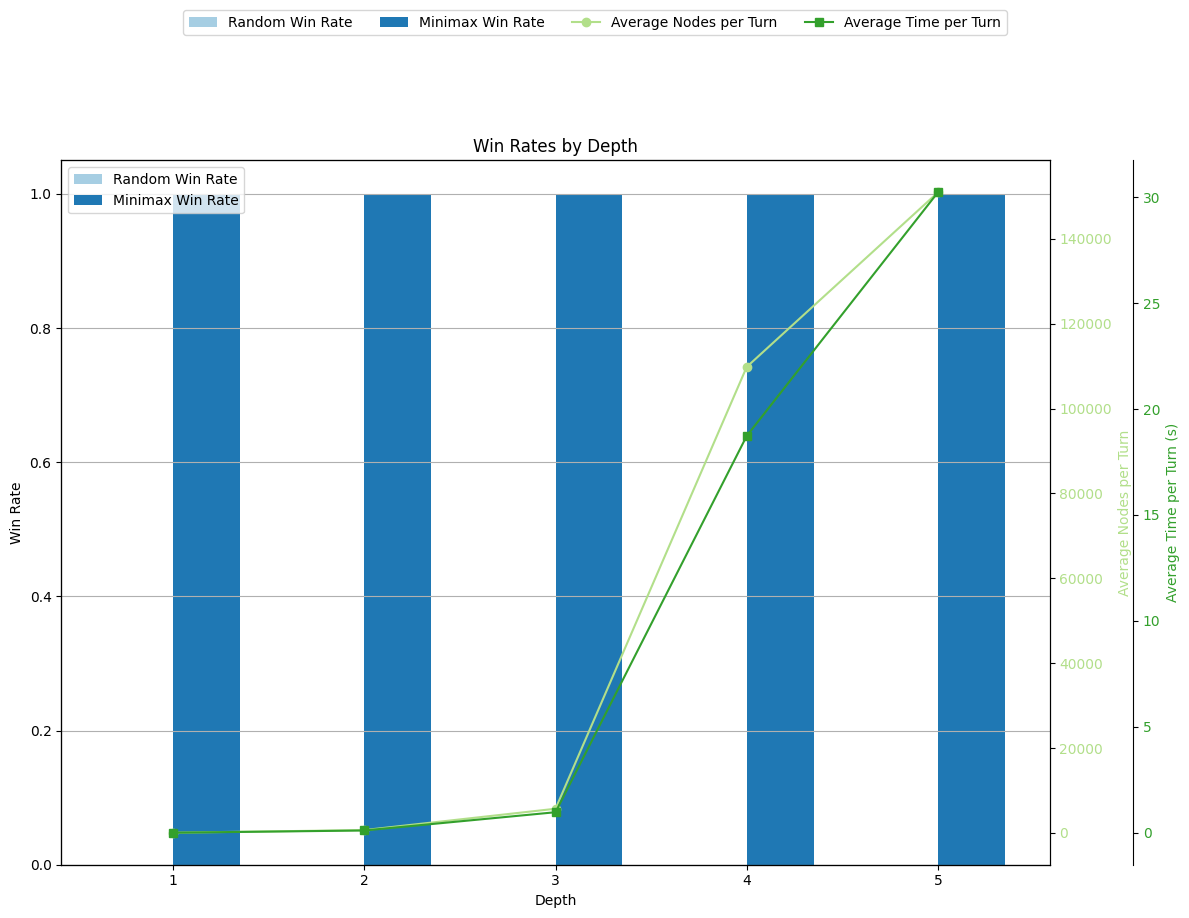

{'1': {'total_games': 61, 'Minimax_wins': 61, 'Random_wins': 0, 'Minimax_win_rate': 1.0, 'Random_win_rate': 0.0, 'avg_nodes_per_turn': 29.626393442622952, 'avg_time_per_turn': 0.009672131147540985}, '2': {'total_games': 61, 'Minimax_wins': 61, 'Random_wins': 0, 'Minimax_win_rate': 1.0, 'Random_win_rate': 0.0, 'avg_nodes_per_turn': 647.2144262295083, 'avg_time_per_turn': 0.11459016393442624}, '3': {'total_games': 61, 'Minimax_wins': 61, 'Random_wins': 0, 'Minimax_win_rate': 1.0, 'Random_win_rate': 0.0, 'avg_nodes_per_turn': 5677.985901639345, 'avg_time_per_turn': 0.9760655737704919}, '4': {'total_games': 61, 'Minimax_wins': 61, 'Random_wins': 0, 'Minimax_win_rate': 1.0, 'Random_win_rate': 0.0, 'avg_nodes_per_turn': 109831.20852459014, 'avg_time_per_turn': 18.72639344262295}, '5': {'total_games': 60, 'Minimax_wins': 60, 'Random_wins': 0, 'Minimax_win_rate': 1.0, 'Random_win_rate': 0.0, 'avg_nodes_per_turn': 150980.60516666665, 'avg_time_per_turn': 30.21766666666667}}
┌─────────┬─────────

In [ ]:
minimax_vs_random_data = calculate_win_rates(minimax_vs_random, "Minimax", "Random")
plot_win_rates(minimax_vs_random_data, "Minimax", "Random")

print(minimax_vs_random_data)

format_data_as_table(minimax_vs_random_data, "Minimax", "Random")

DataFrame columns: Index(['winner', 'starter', 'total_turns', 'win_direction', 'ab_pruning',
       't_tables', 'depth', 'turn_times', 'average_turn_time', 'turn_nodes',
       'average_turn_nodes'],
      dtype='object')


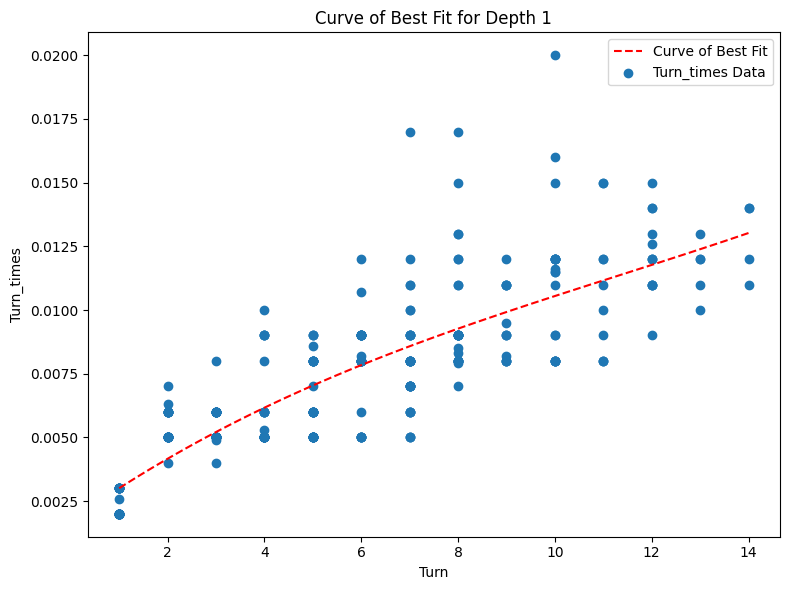

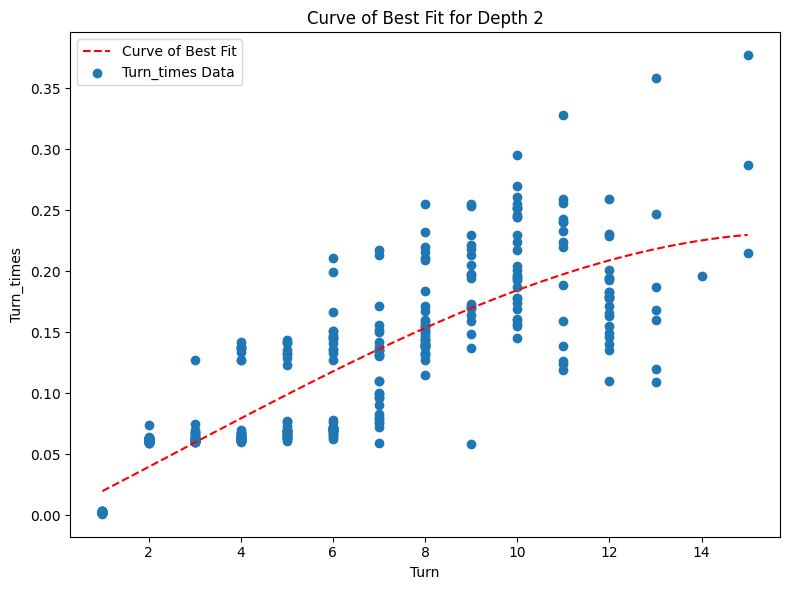

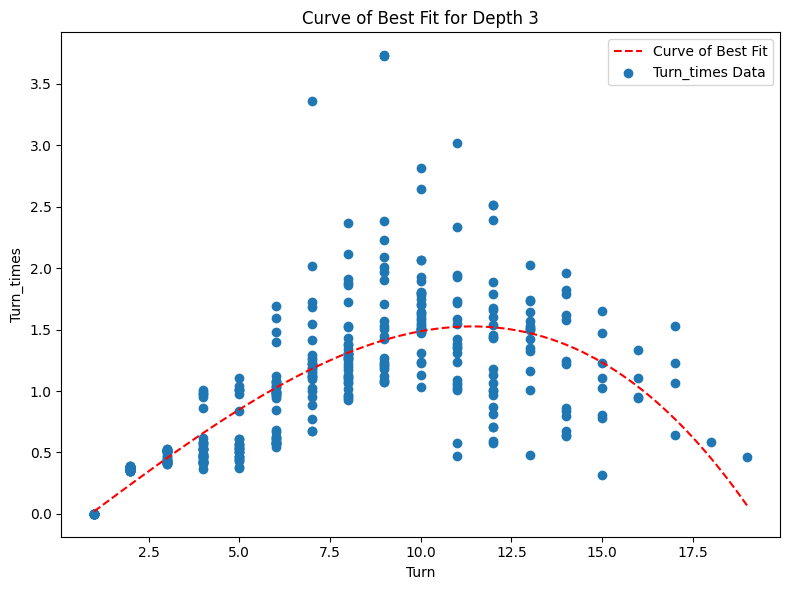

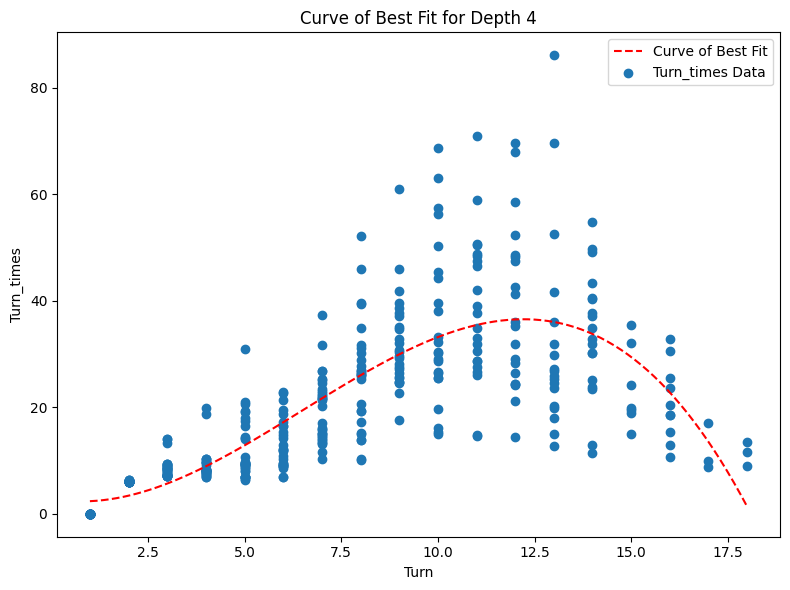

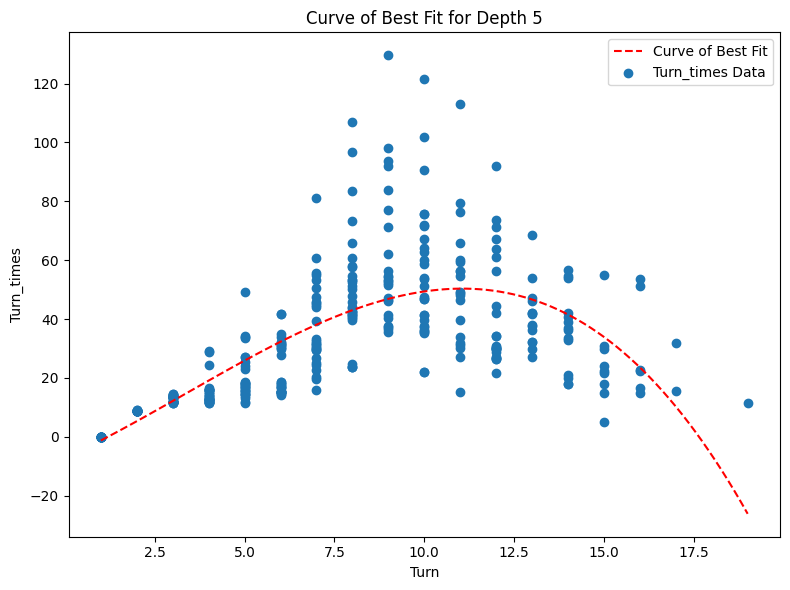

In [ ]:
group_and_plot_by_depth_cobf(minimax_vs_random, 'turn_times')


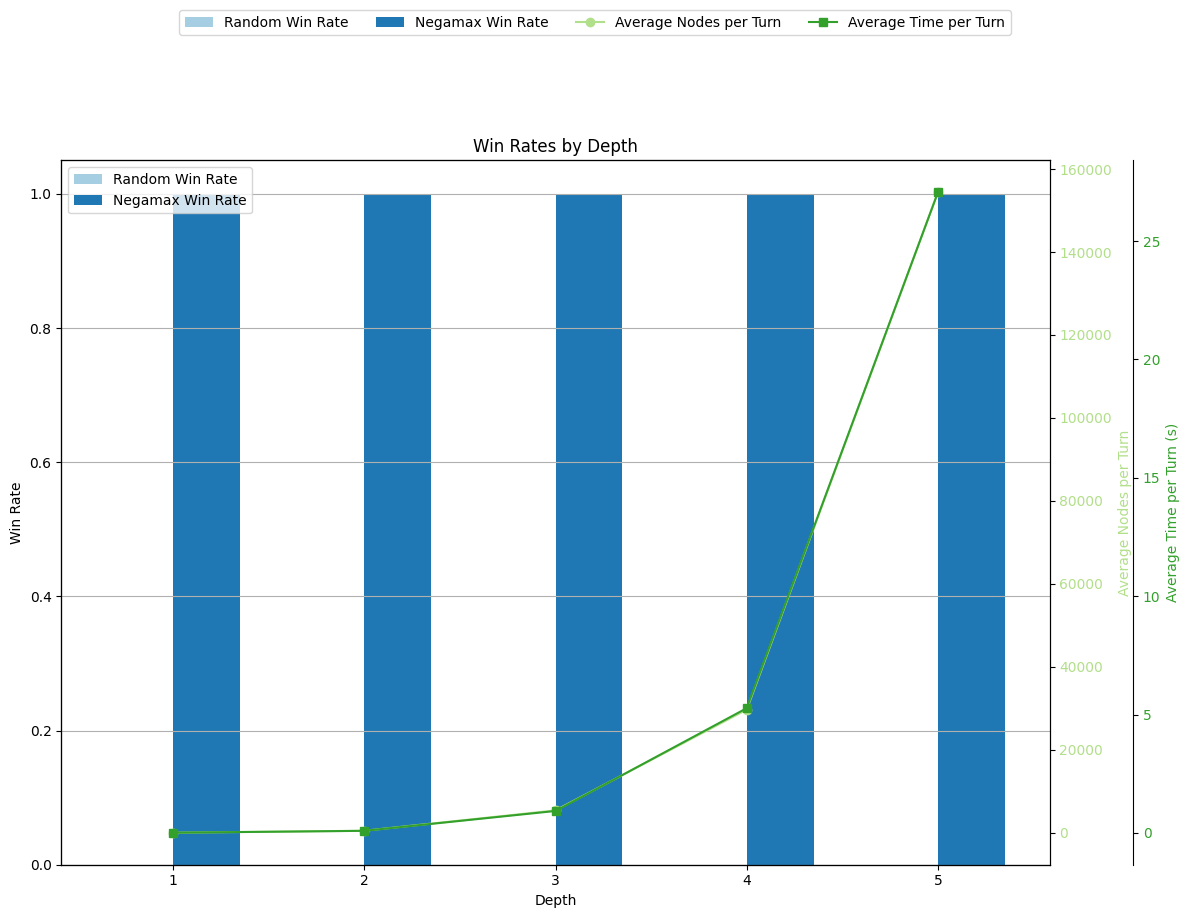

{'1': {'total_games': 59, 'Negamax_wins': 59, 'Random_wins': 0, 'Negamax_win_rate': 1.0, 'Random_win_rate': 0.0, 'avg_nodes_per_turn': 28.260847457627122, 'avg_time_per_turn': 0.010000000000000002}, '2': {'total_games': 59, 'Negamax_wins': 59, 'Random_wins': 0, 'Negamax_win_rate': 1.0, 'Random_win_rate': 0.0, 'avg_nodes_per_turn': 499.94440677966105, 'avg_time_per_turn': 0.0894915254237288}, '3': {'total_games': 59, 'Negamax_wins': 59, 'Random_wins': 0, 'Negamax_win_rate': 1.0, 'Random_win_rate': 0.0, 'avg_nodes_per_turn': 5411.834237288135, 'avg_time_per_turn': 0.9284745762711862}, '4': {'total_games': 59, 'Negamax_wins': 59, 'Random_wins': 0, 'Negamax_win_rate': 1.0, 'Random_win_rate': 0.0, 'avg_nodes_per_turn': 29686.781864406777, 'avg_time_per_turn': 5.269322033898304}, '5': {'total_games': 59, 'Negamax_wins': 59, 'Random_wins': 0, 'Negamax_win_rate': 1.0, 'Random_win_rate': 0.0, 'avg_nodes_per_turn': 154367.7944067797, 'avg_time_per_turn': 27.056101694915252}}
┌─────────┬─────────

In [ ]:
negamax_vs_random_data = calculate_win_rates(negamax_vs_random, "Negamax", "Random")
plot_win_rates(negamax_vs_random_data, "Negamax", "Random")

print(negamax_vs_random_data)

format_data_as_table(negamax_vs_random_data, "Negamax", "Random")

DataFrame columns: Index(['winner', 'starter', 'total_turns', 'win_direction', 'ab_pruning',
       't_tables', 'depth', 'turn_times', 'average_turn_time', 'turn_nodes',
       'average_turn_nodes'],
      dtype='object')


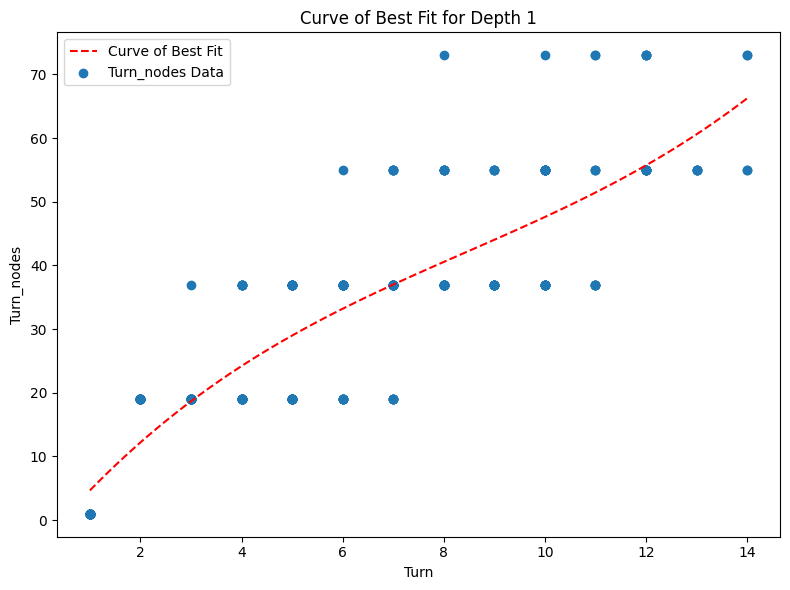

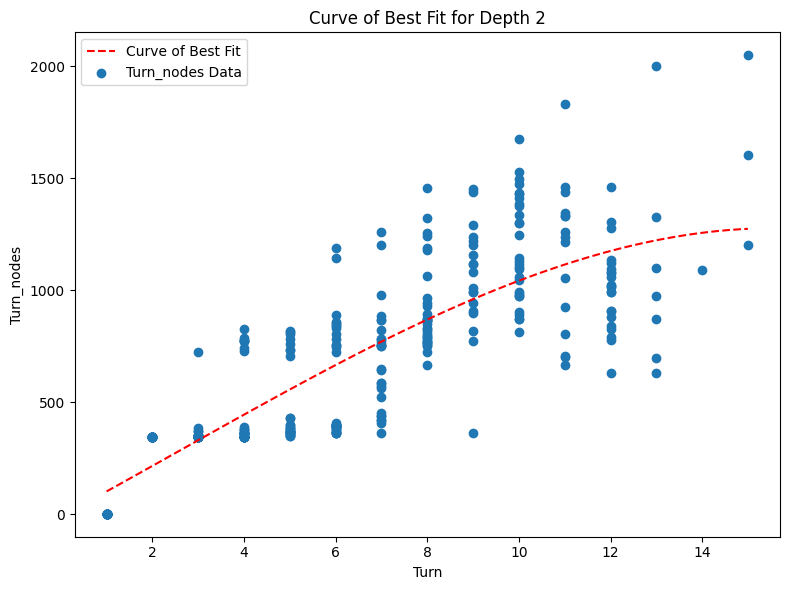

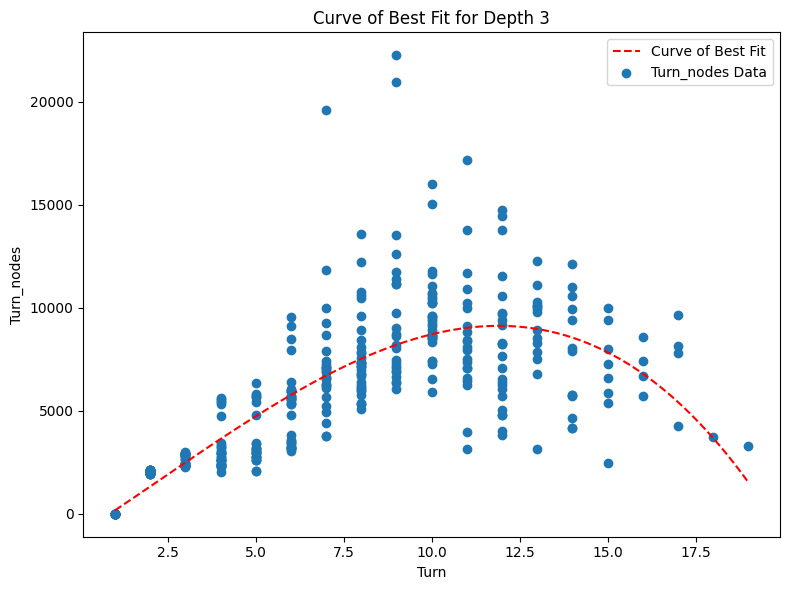

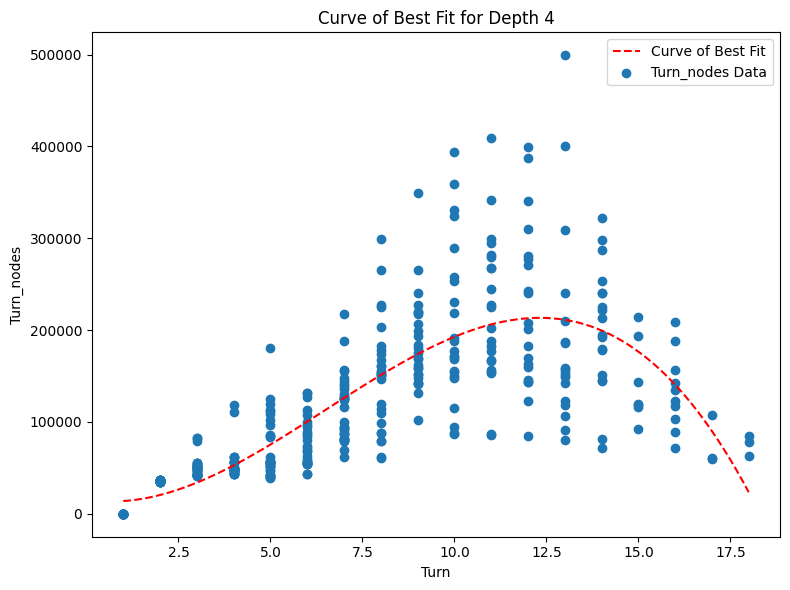

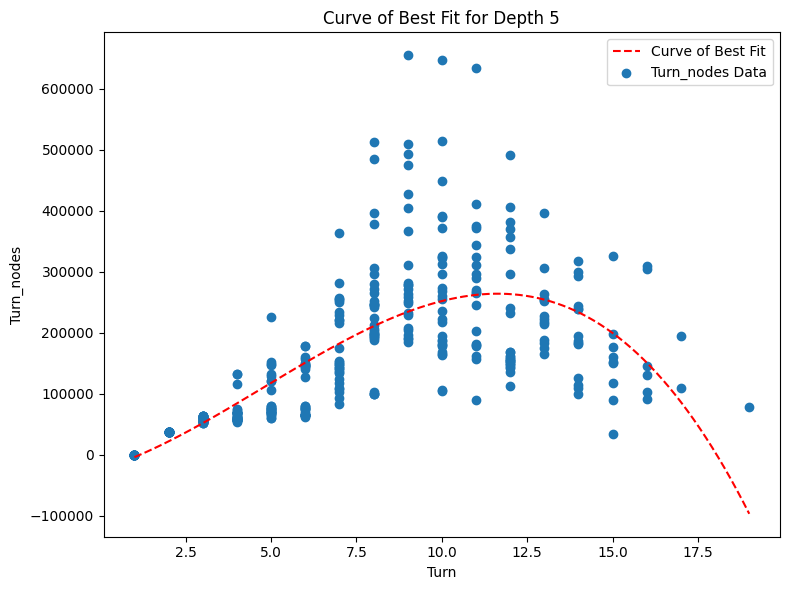

In [ ]:
group_and_plot_by_depth_cobf(minimax_vs_random, "turn_nodes")

DataFrame columns: Index(['winner', 'starter', 'total_turns', 'win_direction', 'ab_pruning',
       't_tables', 'depth', 'turn_times', 'average_turn_time', 'turn_nodes',
       'average_turn_nodes'],
      dtype='object')


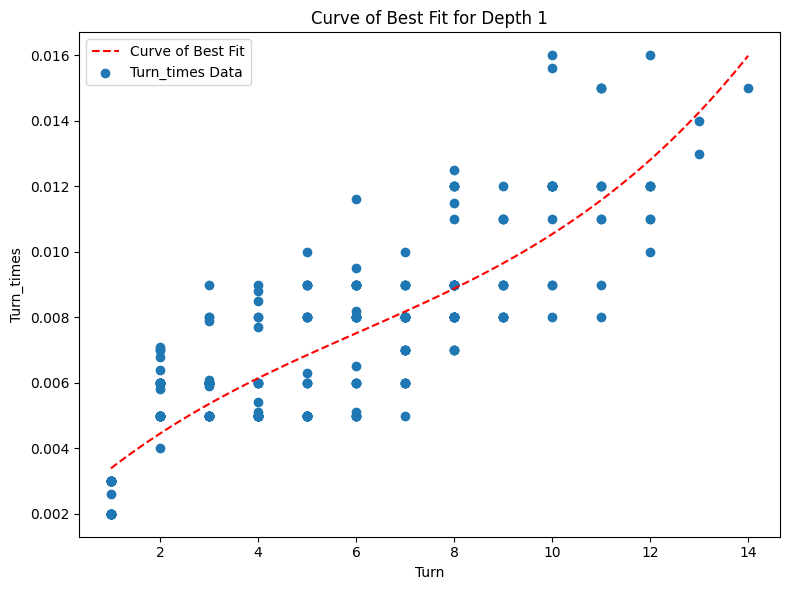

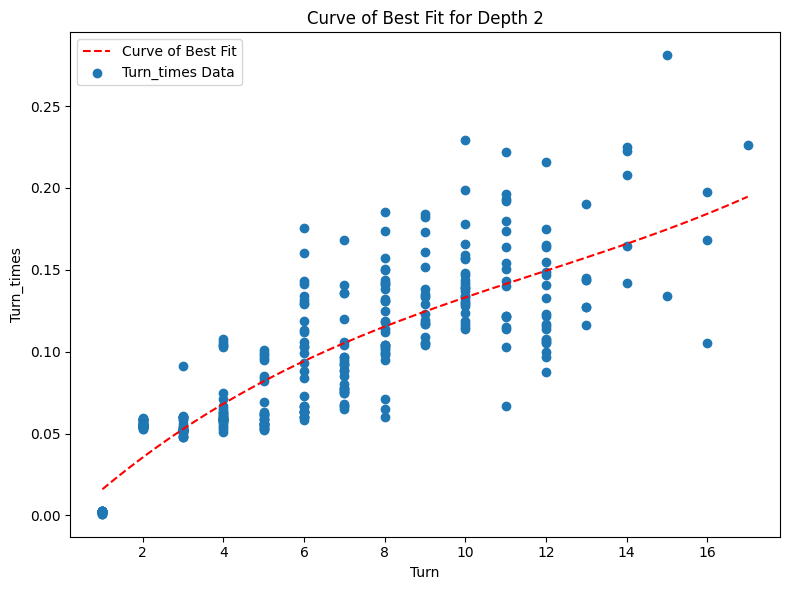

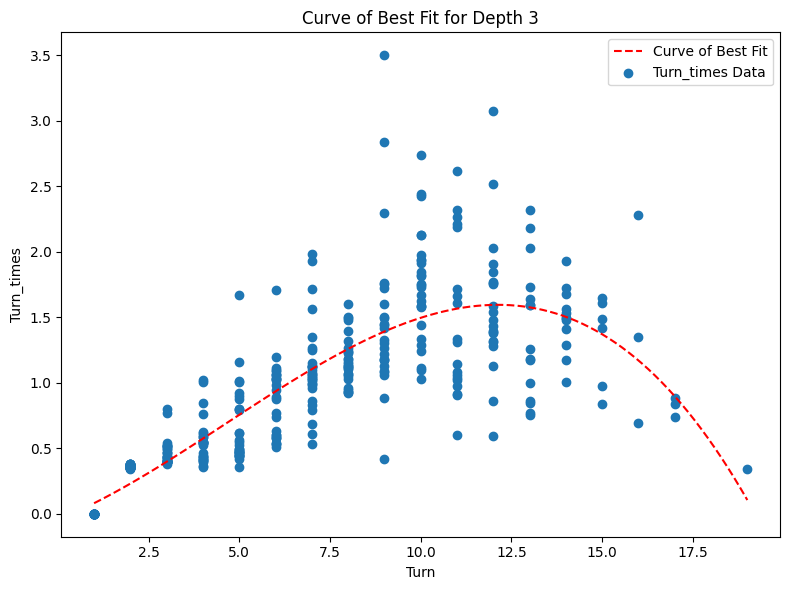

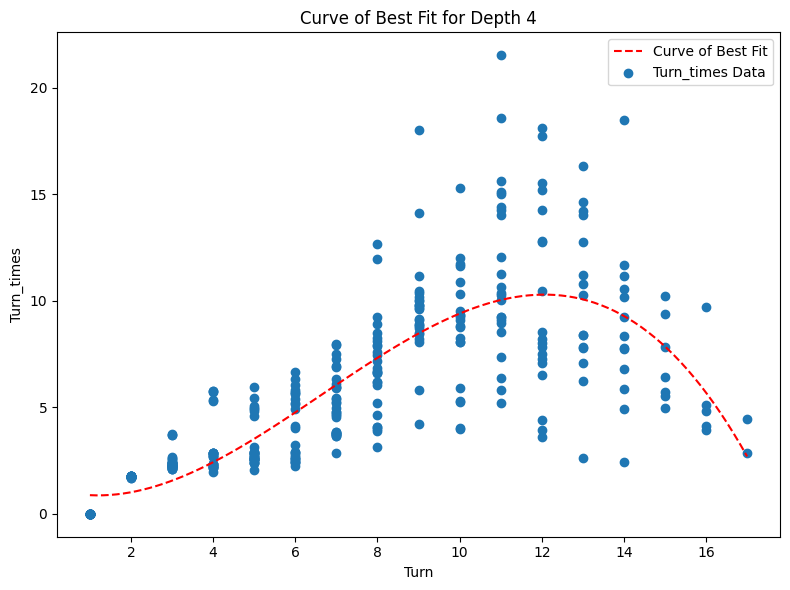

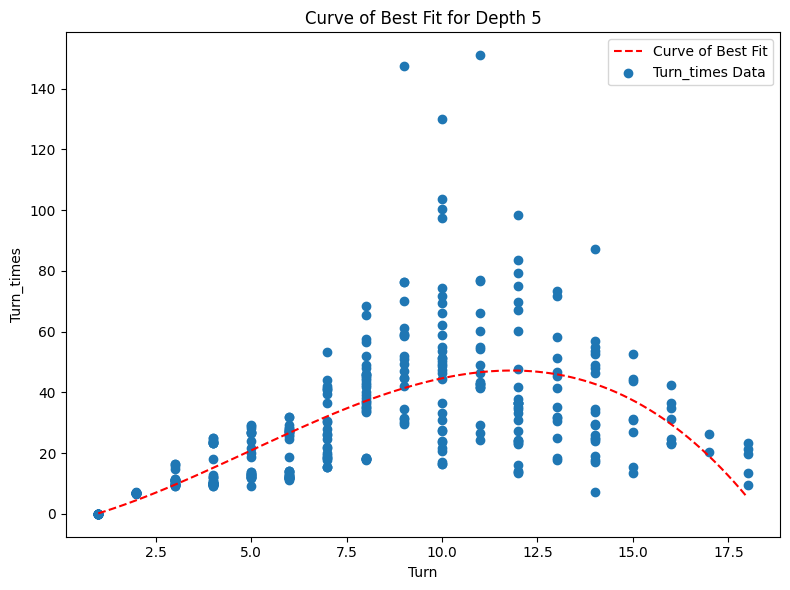

In [ ]:
group_and_plot_by_depth_cobf(negamax_vs_random, 'turn_times')

DataFrame columns: Index(['winner', 'starter', 'total_turns', 'win_direction', 'ab_pruning',
       't_tables', 'depth', 'turn_times', 'average_turn_time', 'turn_nodes',
       'average_turn_nodes'],
      dtype='object')


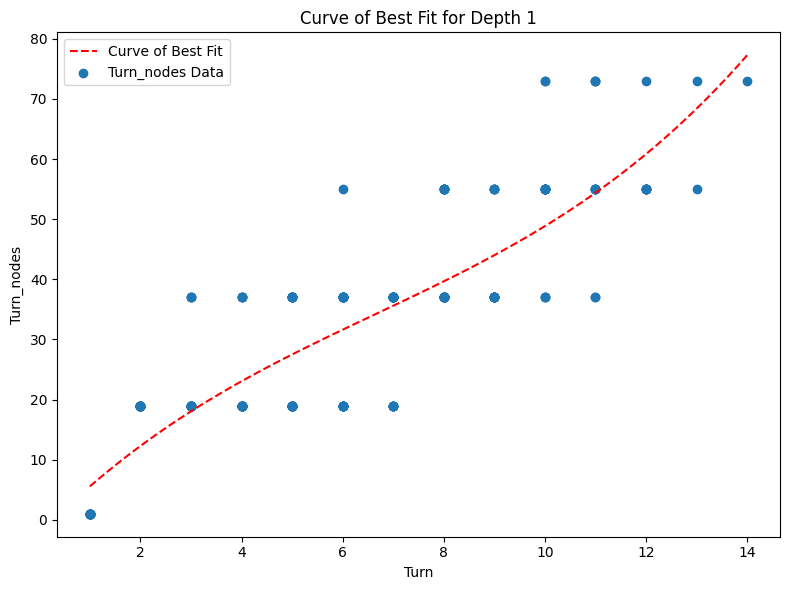

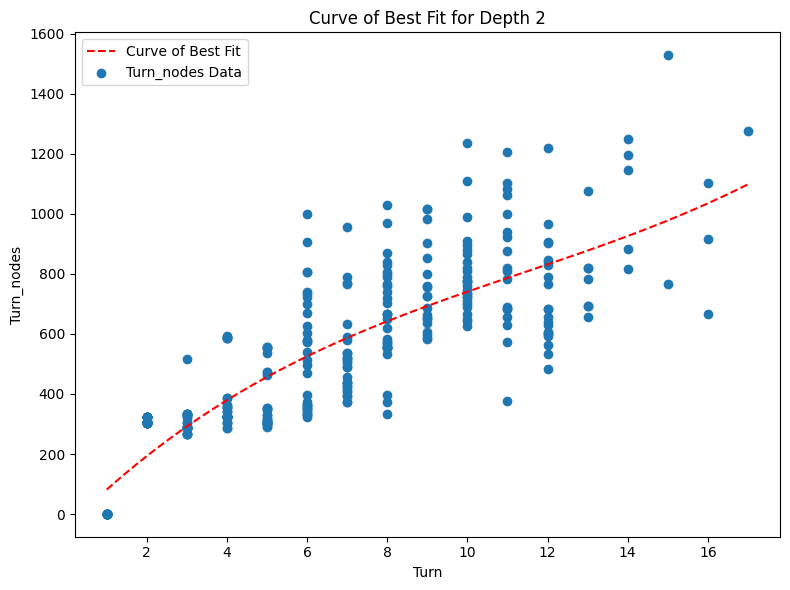

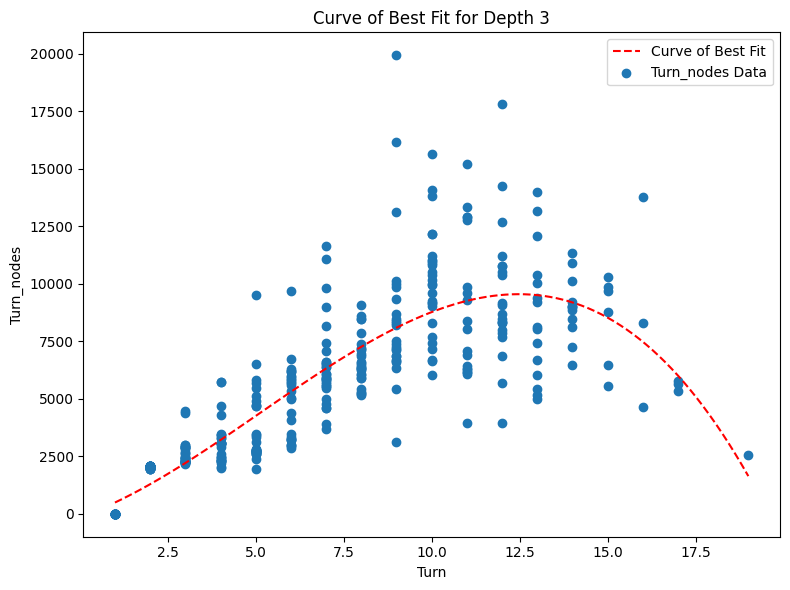

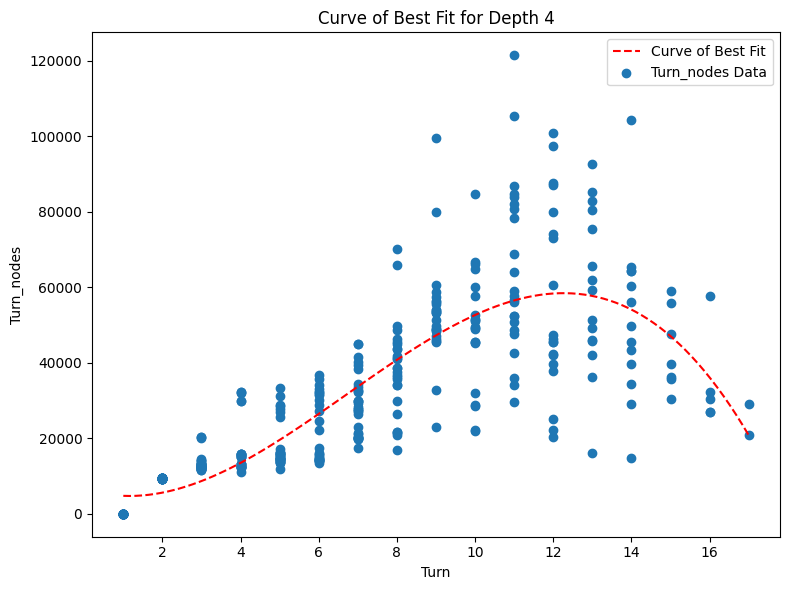

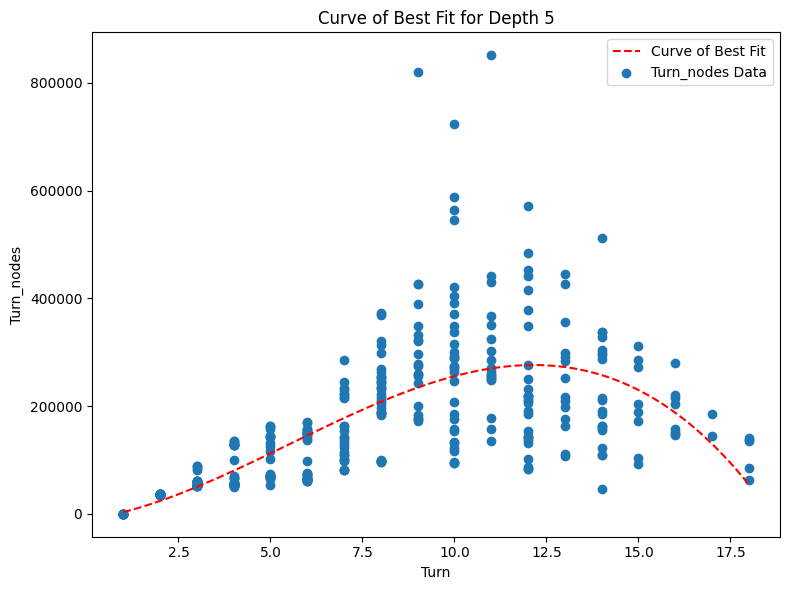

In [ ]:
group_and_plot_by_depth_cobf(negamax_vs_random, 'turn_nodes')

In [ ]:
def group_and_plot_by_performance(filename, plot_type_main, plot_type_sub):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(filename)
    
    # Print the DataFrame columns to check if the chosen plot type exists
    print("DataFrame columns:", df.columns)
    
    # Convert the boolean columns from strings to actual booleans
    df['ab_pruning'] = df['ab_pruning'].astype(bool)
    df['t_tables'] = df['t_tables'].astype(bool)
    
    # Check if the chosen plot type columns exist
    if plot_type_main in df.columns and plot_type_sub in df.columns:
        df[plot_type_main] = df[plot_type_main].apply(lambda x: eval(x))
        df[plot_type_sub] = df[plot_type_sub].apply(lambda x: eval(x))
    else:
        print(f"'{plot_type_main}' or '{plot_type_sub}' column not found in the DataFrame.")
        return

    # Create groups manually
    groups = {
        'True_True': df[(df['ab_pruning'] == True) & (df['t_tables'] == True)],
        'True_False': df[(df['ab_pruning'] == True) & (df['t_tables'] == False)],
        'False_True': df[(df['ab_pruning'] == False) & (df['t_tables'] == True)],
        'False_False': df[(df['ab_pruning'] == False) & (df['t_tables'] == False)]
    }

    for group_name, group in groups.items():
        if group.empty:
            continue
        
        for depth in group['depth'].unique():
            depth_group = group[group['depth'] == depth]
            
            fig, axs = plt.subplots(2, 1, figsize=(10, 12))
            
            for index, row in depth_group.iterrows():
                data_main = row[plot_type_main]
                data_sub = row[plot_type_sub]
                x_vals_main = []
                y_vals_main = []
                x_vals_sub = []
                y_vals_sub = []

                if row['starter'] == 'Minimax':
                    for i in range(len(data_main)):
                        x_vals_main.append(i * 2 + 1)  # Minimax's turns are 1, 3, 5, ...
                        y_vals_main.append(data_main[i])
                        x_vals_sub.append(i * 2 + 1)
                        y_vals_sub.append(data_sub[i])
                else:
                    for i in range(len(data_main)):
                        x_vals_main.append(i * 2 + 2)  # Minimax's turns are 2, 4, 6, ...
                        y_vals_main.append(data_main[i])
                        x_vals_sub.append(i * 2 + 2)
                        y_vals_sub.append(data_sub[i])

                axs[0].plot(x_vals_main, y_vals_main, marker='o', label=f"Game {index + 1}")
                axs[1].plot(x_vals_sub, y_vals_sub, marker='o', label=f"Game {index + 1}")

            # Extract the ab_pruning and t_tables values from the group name
            ab_pruning, t_tables = group_name.split('_')
            
            axs[0].set_title(f'{plot_type_main.capitalize()} for ab_pruning = {ab_pruning}, transposition tables = {t_tables}, depth = {depth}')
            axs[0].set_xlabel('Turn')
            axs[0].set_ylabel(f'{plot_type_main.capitalize()}')
            axs[0].legend()

            axs[1].set_title(f'{plot_type_sub.capitalize()} for ab_pruning = {ab_pruning}, transposition tables = {t_tables}, depth = {depth}')
            axs[1].set_xlabel('Turn')
            axs[1].set_ylabel(f'{plot_type_sub.capitalize()}')
            axs[1].legend()
            
            plt.tight_layout()
            plt.show()



In [ ]:
def calculate_and_print_averages(filename):
    # Read the CSV file into a DataFrame with the provided header
    new_header = ["winner","starter","total_turns","win_direction","ab_pruning","t_tables","depth","turn_times","average_turn_time","turn_nodes","average_turn_nodes"]
    df = pd.read_csv(filename, names=new_header, header=0)
    
    # Print the column names to check if they match the new header
    print("DataFrame columns:", df.columns)

    # Convert the boolean columns from strings to actual booleans
    df['ab_pruning'] = df['ab_pruning'].astype(bool)
    df['t_tables'] = df['t_tables'].astype(bool)

    # Convert the string representations of lists into actual lists
    df['turn_times'] = df['turn_times'].apply(lambda x: eval(x))
    df['turn_nodes'] = df['turn_nodes'].apply(lambda x: eval(x))

    # Create groups manually
    groups = {
        'True_True': df[(df['ab_pruning'] == True) & (df['t_tables'] == True)],
        'True_False': df[(df['ab_pruning'] == True) & (df['t_tables'] == False)],
        'False_True': df[(df['ab_pruning'] == False) & (df['t_tables'] == True)],
        'False_False': df[(df['ab_pruning'] == False) & (df['t_tables'] == False)]
    }

    for group_name, group in groups.items():
        if group.empty:
            continue

        print(f"Group: {group_name}")
        
        for depth in group['depth'].unique():
            depth_group = group[group['depth'] == depth]

            total_turns = sum(depth_group['turn_times'].apply(len))
            total_nodes = sum([sum(nodes) for nodes in depth_group['turn_nodes']])
            total_time = sum([sum(times) for times in depth_group['turn_times']])

            avg_nodes_per_turn = total_nodes / total_turns
            avg_time_per_turn = total_time / total_turns

            print(f"Depth {depth}:")
            print(f"  Average nodes evaluated per turn: {avg_nodes_per_turn:.2f}")
            print(f"  Average time taken per turn: {avg_time_per_turn:.2f} seconds")
            print()

DataFrame columns: Index(['winner', 'starter', 'total_turns', 'win_direction', 'ab_pruning',
       't_tables', 'depth', 'turn_times', 'average_turn_time', 'turn_nodes',
       'average_turn_nodes'],
      dtype='object')


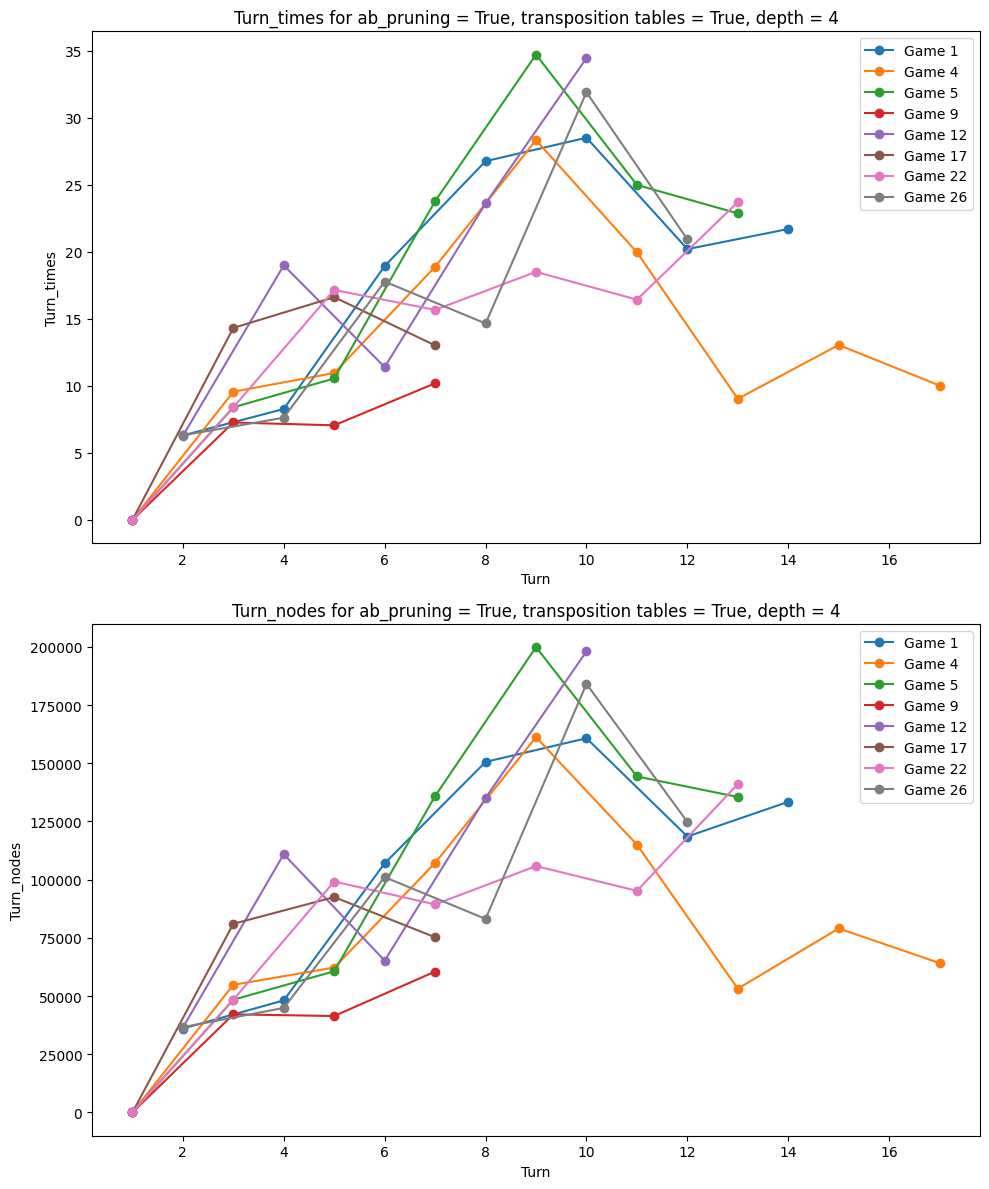

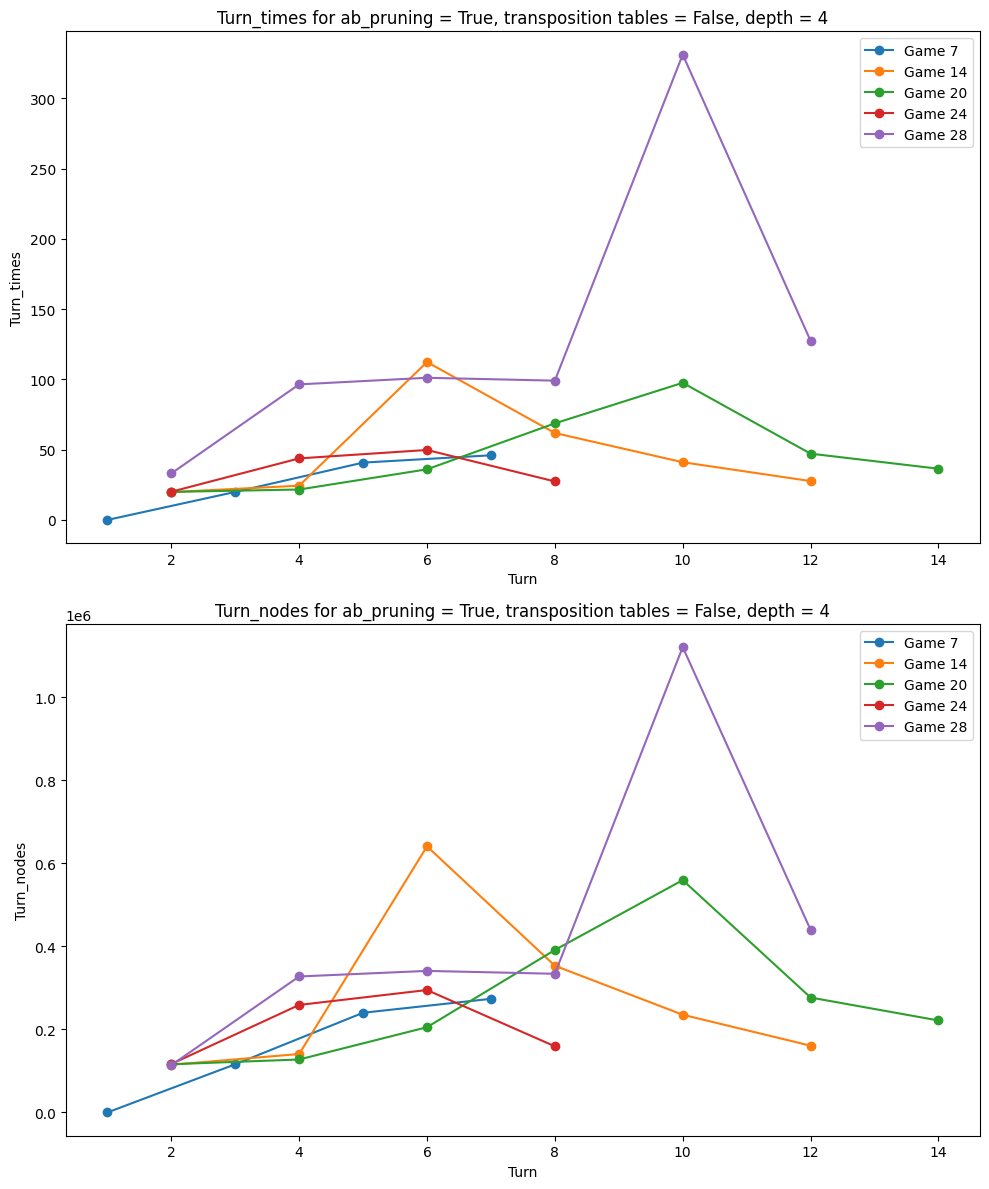

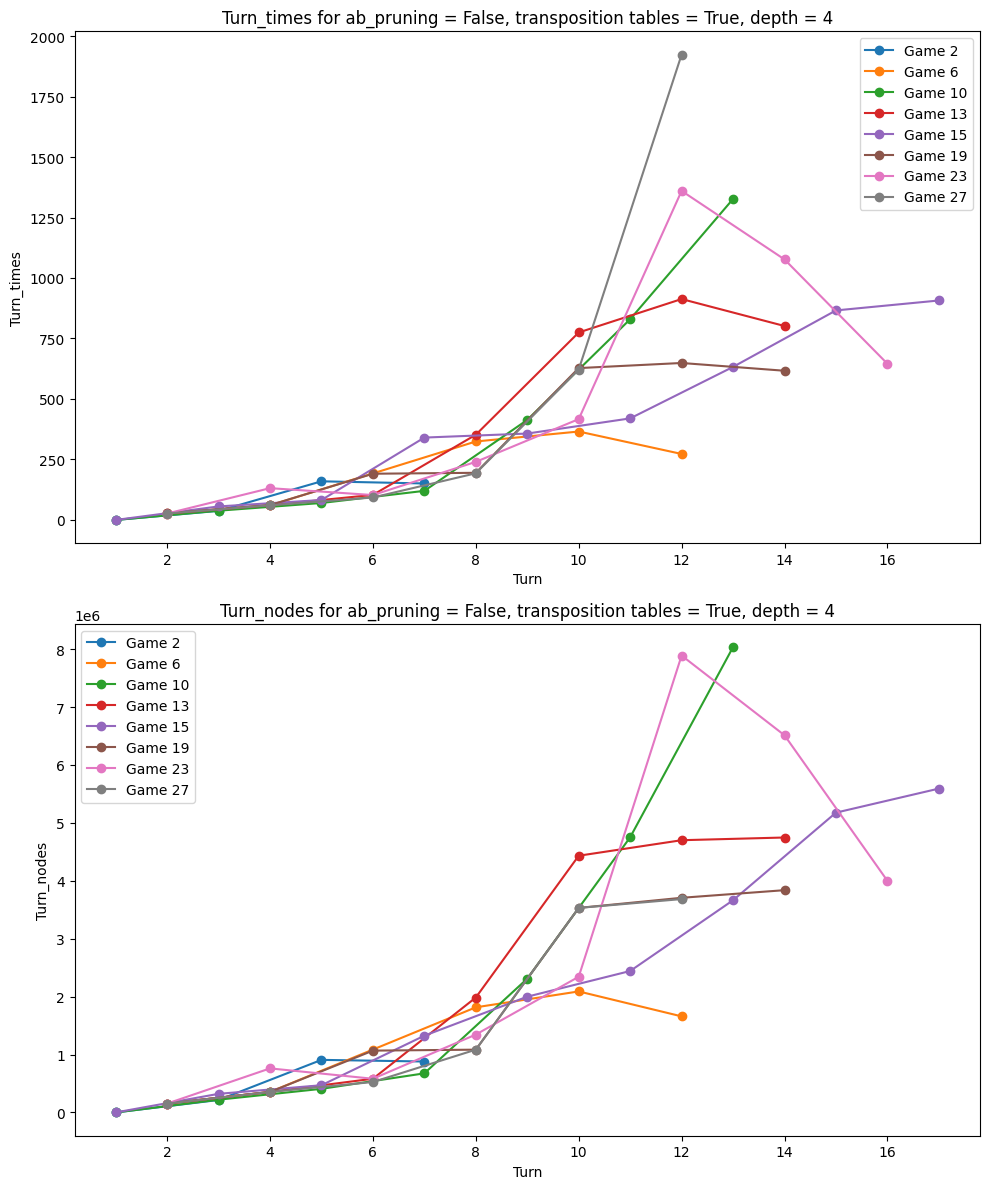

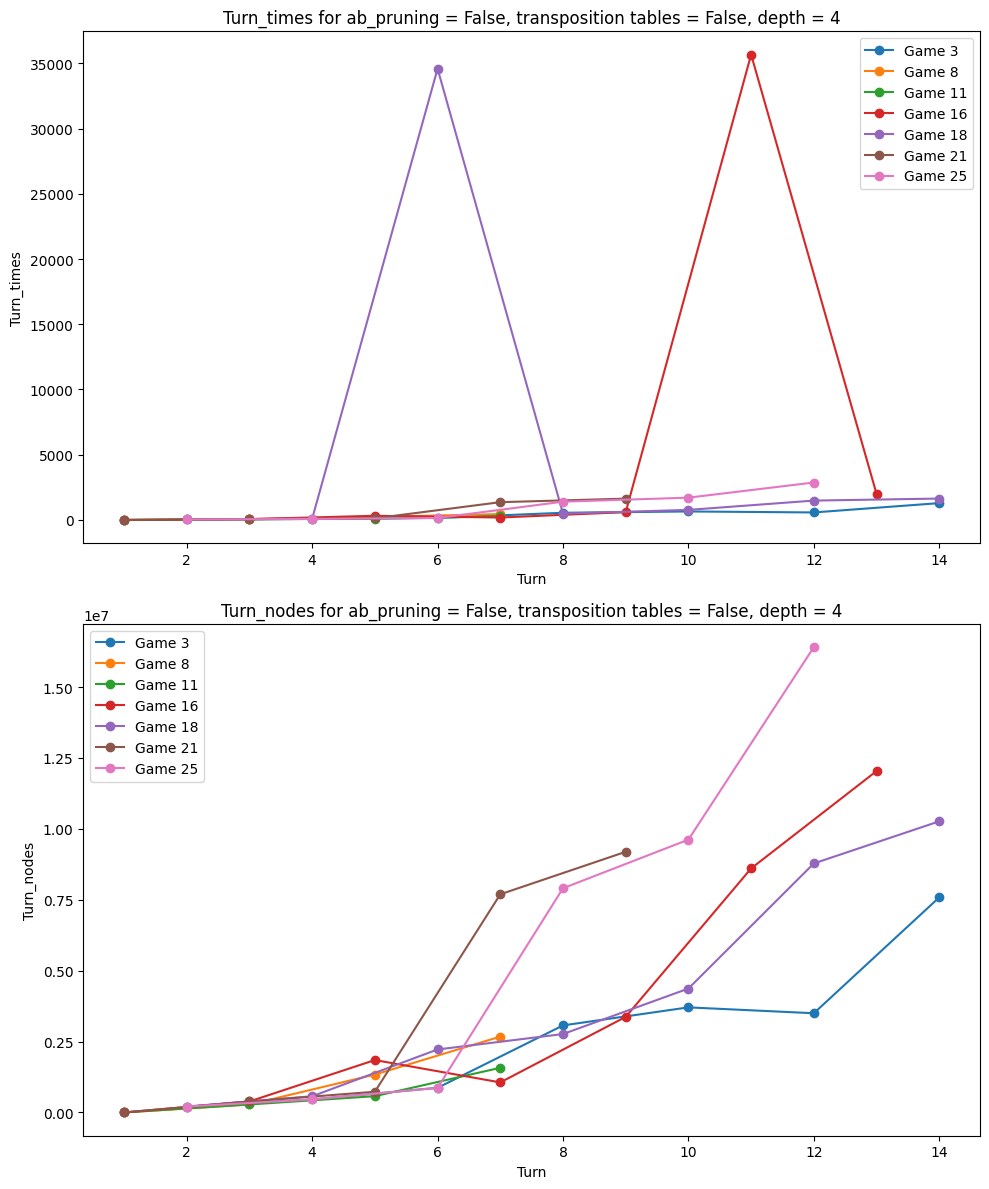

In [ ]:
group_and_plot_by_performance('Results/minimax_vs_random_abp_tt.csv', 'turn_times', 'turn_nodes')

In [ ]:
calculate_and_print_averages('Results/minimax_vs_random_abp_tt.csv')

DataFrame columns: Index(['winner', 'starter', 'total_turns', 'win_direction', 'ab_pruning',
       't_tables', 'depth', 'turn_times', 'average_turn_time', 'turn_nodes',
       'average_turn_nodes'],
      dtype='object')
Group: True_True
Depth 4:
  Average nodes evaluated per turn: 87102.08
  Average time taken per turn: 15.06 seconds

Group: True_False
Depth 4:
  Average nodes evaluated per turn: 284615.78
  Average time taken per turn: 61.14 seconds

Group: False_True
Depth 4:
  Average nodes evaluated per turn: 2039863.09
  Average time taken per turn: 377.19 seconds

Group: False_False
Depth 4:
  Average nodes evaluated per turn: 3401430.17
  Average time taken per turn: 2296.83 seconds



{'1': {'total_games': 134, 'Minimax_wins': 82, 'Greedy_wins': 52, 'Minimax_win_rate': 0.6119402985074627, 'Greedy_win_rate': 0.3880597014925373, 'avg_nodes_per_turn': 45.823134328358215, 'avg_time_per_turn': 0.010298507462686566}, '2': {'total_games': 134, 'Minimax_wins': 132, 'Greedy_wins': 2, 'Minimax_win_rate': 0.9850746268656716, 'Greedy_win_rate': 0.014925373134328358, 'avg_nodes_per_turn': 1118.4973134328357, 'avg_time_per_turn': 0.20320895522388058}, '3': {'total_games': 134, 'Minimax_wins': 132, 'Greedy_wins': 2, 'Minimax_win_rate': 0.9850746268656716, 'Greedy_win_rate': 0.014925373134328358, 'avg_nodes_per_turn': 8038.127985074626, 'avg_time_per_turn': 1.4494776119402983}, '4': {'total_games': 133, 'Minimax_wins': 132, 'Greedy_wins': 1, 'Minimax_win_rate': 0.9924812030075187, 'Greedy_win_rate': 0.007518796992481203, 'avg_nodes_per_turn': 156631.16992481204, 'avg_time_per_turn': 27.528947368421054}, '5': {'total_games': 3, 'Minimax_wins': 3, 'Greedy_wins': 0, 'Minimax_win_rate'

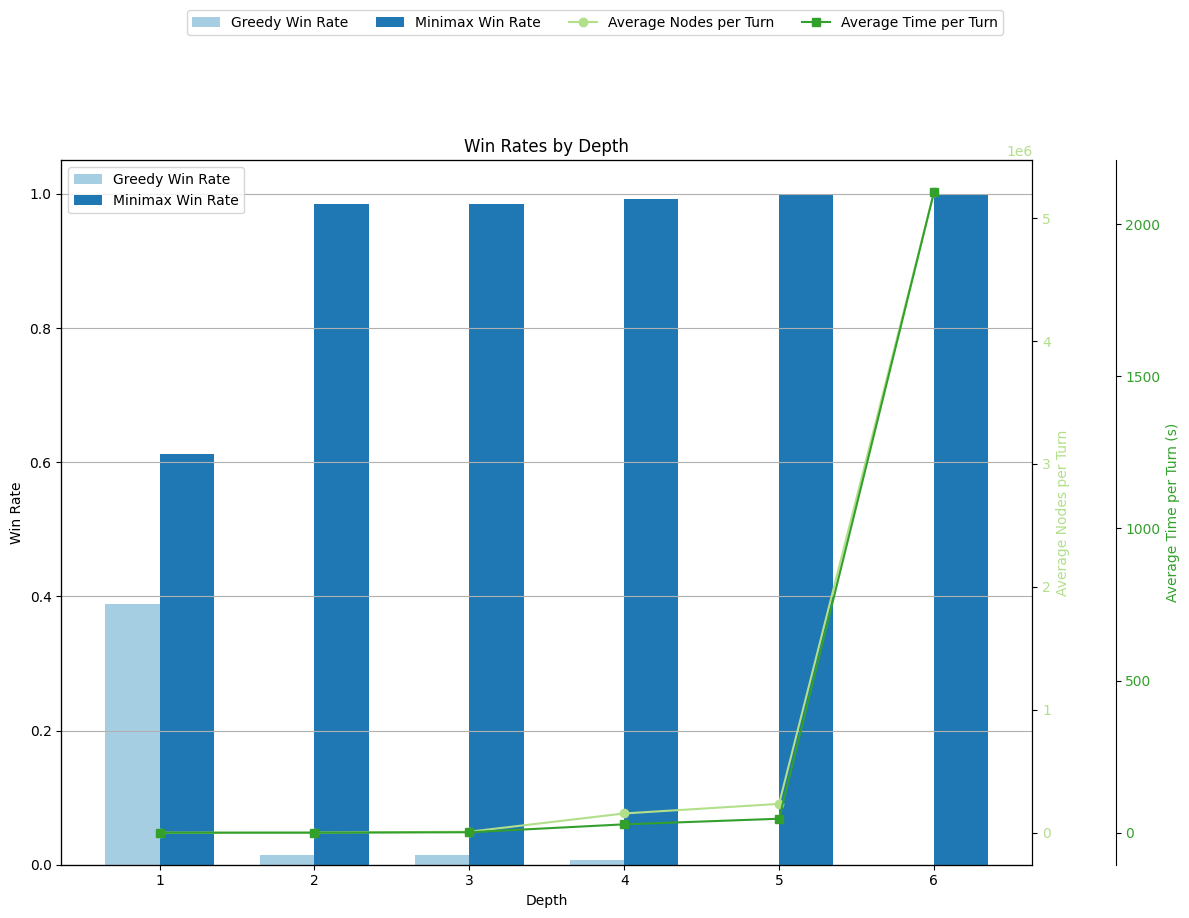

In [ ]:
minimax_vs_greedy_data = calculate_win_rates("Results/minimax_vs_greedy.csv", "Minimax", "Greedy")

print(minimax_vs_greedy_data)

plot_win_rates(minimax_vs_greedy_data, "Minimax", "Greedy")


{'1': {'total_games': 103, 'Negamax_wins': 58, 'Greedy_wins': 45, 'Negamax_win_rate': 0.5631067961165048, 'Greedy_win_rate': 0.4368932038834951, 'avg_nodes_per_turn': 43.52718446601942, 'avg_time_per_turn': 0.010194174757281552}, '2': {'total_games': 103, 'Negamax_wins': 95, 'Greedy_wins': 8, 'Negamax_win_rate': 0.9223300970873787, 'Greedy_win_rate': 0.07766990291262135, 'avg_nodes_per_turn': 781.7942718446602, 'avg_time_per_turn': 0.1446601941747573}, '3': {'total_games': 102, 'Negamax_wins': 97, 'Greedy_wins': 5, 'Negamax_win_rate': 0.9509803921568627, 'Greedy_win_rate': 0.049019607843137254, 'avg_nodes_per_turn': 8558.709803921569, 'avg_time_per_turn': 1.5353921568627453}, '4': {'total_games': 102, 'Negamax_wins': 101, 'Greedy_wins': 1, 'Negamax_win_rate': 0.9901960784313726, 'Greedy_win_rate': 0.00980392156862745, 'avg_nodes_per_turn': 55573.18823529411, 'avg_time_per_turn': 10.156862745098042}, '5': {'total_games': 22, 'Negamax_wins': 22, 'Greedy_wins': 0, 'Negamax_win_rate': 1.0,

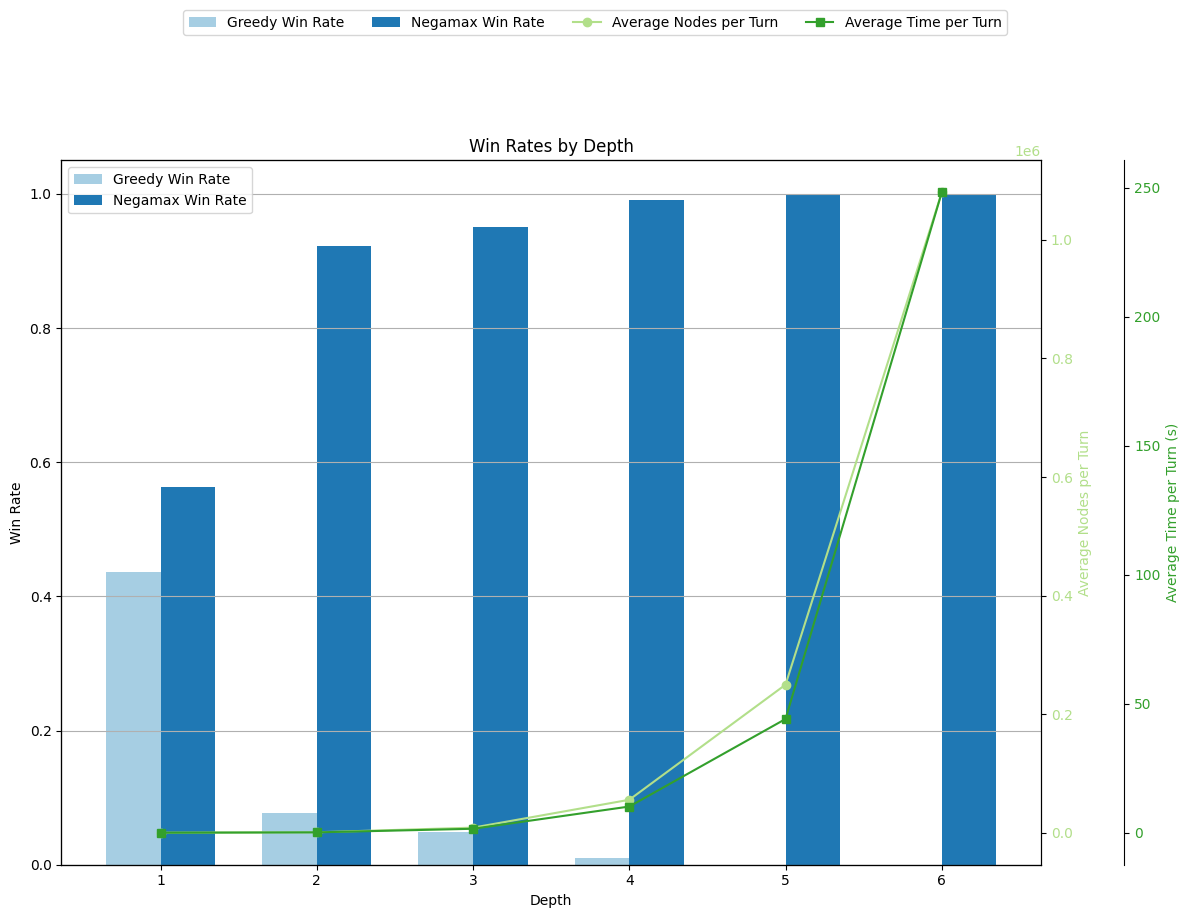

In [ ]:
negamax_vs_greedy_data = calculate_win_rates("Results/negamax_vs_greedy.csv", "Negamax", "Greedy")

print(negamax_vs_greedy_data)

plot_win_rates(negamax_vs_greedy_data, "Negamax", "Greedy")

In [ ]:
def plot_win_rates_and_nodes(negamax_data, minimax_data):
    depths = sorted(negamax_data.keys(), key=lambda x: int(x))
    
    negamax_win_rates = [negamax_data[depth]['Negamax_win_rate'] for depth in depths]
    negamax_nodes_per_turn = [negamax_data[depth]['avg_nodes_per_turn'] for depth in depths]
    
    minimax_win_rates = [minimax_data[depth]['Minimax_win_rate'] for depth in depths]
    minimax_nodes_per_turn = [minimax_data[depth]['avg_nodes_per_turn'] for depth in depths]
    
    x = range(len(depths))
    
    bar_width = 0.35  # Width of the bars
    
    # Set the color palette
    palette = sns.color_palette("Paired", 6)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    # Plot win rates
    ax1.bar(x, negamax_win_rates, width=bar_width, label='Negamax Win Rate', color=palette[0], align='center')
    ax1.bar([i + bar_width for i in x], minimax_win_rates, width=bar_width, label='Minimax Win Rate', color=palette[1], align='center')
    
    ax1.set_xlabel('Depth')
    ax1.set_ylabel('Win Rate')
    ax1.set_title('Win Rates by Depth')
    ax1.set_xticks([i + bar_width / 2 for i in x])
    ax1.set_xticklabels(depths)
    ax1.legend(loc='upper left')
    ax1.grid(True, axis='y')
    
    # Plot nodes per turn
    ax2.plot([i + bar_width / 2 for i in x], negamax_nodes_per_turn, label='Negamax Average Nodes per Turn', color=palette[2], marker='o')
    ax2.plot([i + bar_width / 2 for i in x], minimax_nodes_per_turn, label='Minimax Average Nodes per Turn', color=palette[3], marker='o')
    
    ax2.set_xlabel('Depth')
    ax2.set_ylabel('Average Nodes per Turn')
    ax2.set_title('Average Nodes per Turn by Depth')
    ax2.set_xticks([i + bar_width / 2 for i in x])
    ax2.set_xticklabels(depths)
    ax2.legend(loc='upper left')
    ax2.grid(True, axis='y')
    
    plt.tight_layout()
    plt.show()

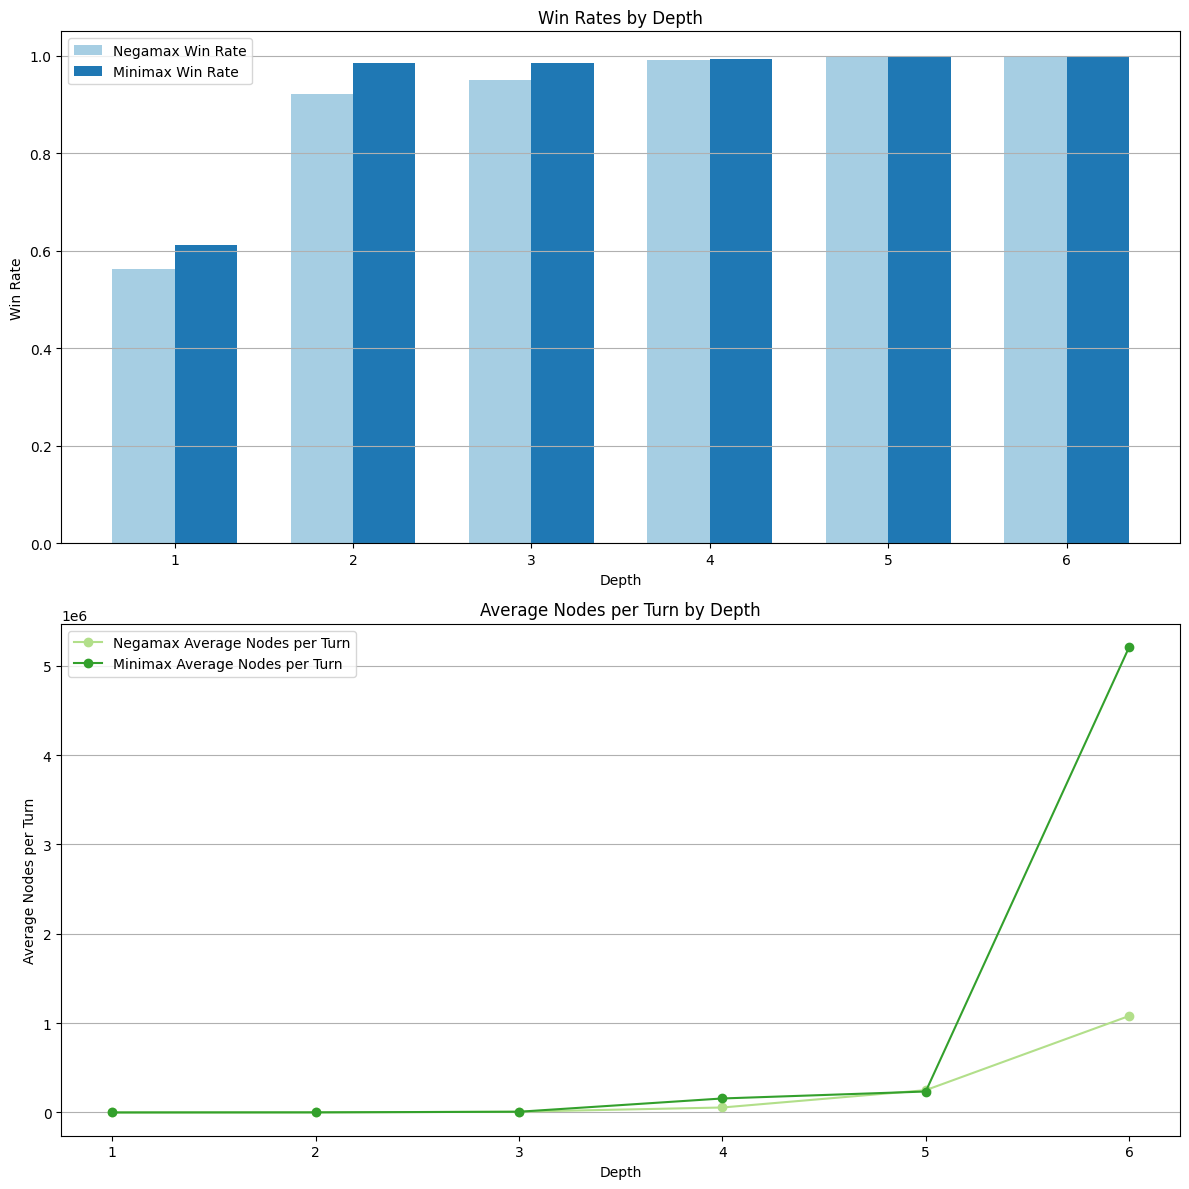

In [ ]:
plot_win_rates_and_nodes(negamax_vs_greedy_data, minimax_vs_greedy_data)

# Minimax VS Negamax

┌─────────────────┬─────────────────┬──────────────────────────┬──────────────────────────┬────────────────────┬────────────────────┐
│   Minimax Depth │   Negamax Depth │   Minimax Avg Nodes/Turn │   Negamax Avg Nodes/Turn │   Minimax Win Rate │   Negamax Win Rate │
├─────────────────┼─────────────────┼──────────────────────────┼──────────────────────────┼────────────────────┼────────────────────┤
│               1 │               1 │                   43.737 │                  42.6348 │           0.565217 │           0.434783 │
├─────────────────┼─────────────────┼──────────────────────────┼──────────────────────────┼────────────────────┼────────────────────┤
│               2 │               2 │                 1155.99  │                 827.94   │           0.652174 │           0.347826 │
├─────────────────┼─────────────────┼──────────────────────────┼──────────────────────────┼────────────────────┼────────────────────┤
│               3 │               3 │                 9964.47 

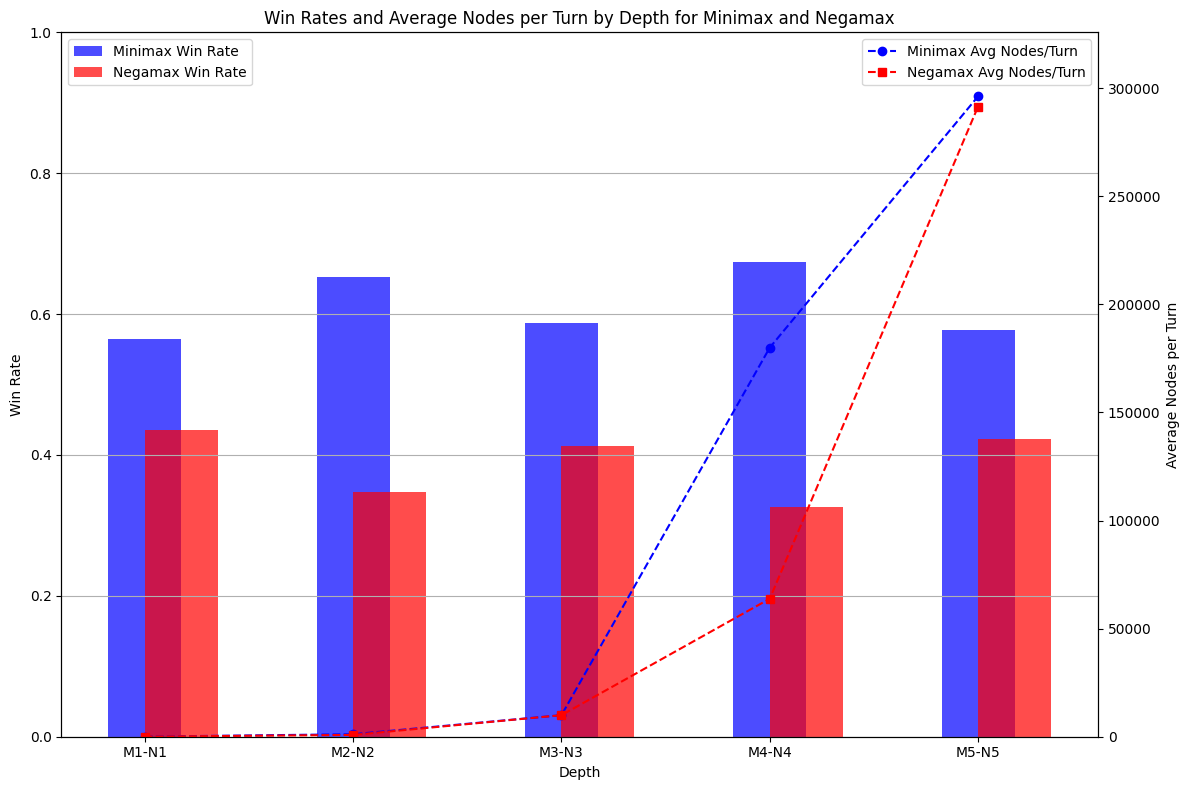

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from tabulate import tabulate
import ast

def extract_average_nodes_per_turn(data):
    avg_nodes_per_turn = []
    for nodes in data:
        nodes_list = ast.literal_eval(nodes)
        avg_nodes_per_turn.append(sum(nodes_list) / len(nodes_list))
    return avg_nodes_per_turn

def calculate_win_rates(filename):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(filename)
    
    # Convert the depth column to string to avoid confusion during grouping
    df['depth_m'] = df['depth_m'].astype(str)
    df['depth_n'] = df['depth_n'].astype(str)
    
    # Group by depth
    depth_groups = df.groupby(['depth_m', 'depth_n'])
    
    win_rates = {}
    
    for (depth_m, depth_n), group in depth_groups:
        total_games = len(group)
        minimax_wins = len(group[group['winner'] == 'Minimax'])
        negamax_wins = len(group[group['winner'] == 'Negamax'])
        
        win_rates[(depth_m, depth_n)] = {
            'total_games': total_games,
            'Minimax_wins': minimax_wins,
            'Negamax_wins': negamax_wins,
            'Minimax_win_rate': minimax_wins / total_games if total_games > 0 else 0,
            'Negamax_win_rate': negamax_wins / total_games if total_games > 0 else 0
        }
    
    return win_rates

def read_and_process_data(filename):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(filename)

    # Extract relevant columns
    minimax_depth = df['depth_m']
    negamax_depth = df['depth_n']
    minimax_nodes = extract_average_nodes_per_turn(df['turn_nodes_m'])
    negamax_nodes = extract_average_nodes_per_turn(df['turn_nodes_n'])
    
    win_rates = calculate_win_rates(filename)
    
    return minimax_depth, negamax_depth, minimax_nodes, negamax_nodes, win_rates

def create_combined_table(minimax_depth, negamax_depth, minimax_nodes, negamax_nodes, win_rates):
    # Create a DataFrame from the extracted data
    data = {
        'Minimax Depth': minimax_depth.astype(str),  # Convert to string
        'Negamax Depth': negamax_depth.astype(str),  # Convert to string
        'Minimax Avg Nodes/Turn': minimax_nodes,
        'Negamax Avg Nodes/Turn': negamax_nodes
    }
    df = pd.DataFrame(data)
    
    # Group by Minimax Depth and Negamax Depth and calculate mean values
    grouped_df = df.groupby(['Minimax Depth', 'Negamax Depth']).mean().reset_index()
    
    # Convert win_rates dictionary to DataFrame
    win_rates_data = []
    for (depth_m, depth_n), rates in win_rates.items():
        win_rates_data.append([depth_m, depth_n, rates['Minimax_win_rate'], rates['Negamax_win_rate']])
    win_rates_df = pd.DataFrame(win_rates_data, columns=['Minimax Depth', 'Negamax Depth', 'Minimax Win Rate', 'Negamax Win Rate'])
    
    # Ensure both DataFrames have the same data type for merging
    win_rates_df['Minimax Depth'] = win_rates_df['Minimax Depth'].astype(str)
    win_rates_df['Negamax Depth'] = win_rates_df['Negamax Depth'].astype(str)
    
    # Merge the two DataFrames
    combined_df = pd.merge(grouped_df, win_rates_df, on=['Minimax Depth', 'Negamax Depth'])
    
    # Print the DataFrame in a nicely formatted table
    print(tabulate(combined_df, headers='keys', tablefmt='simple_grid', showindex=False))
    
    return combined_df

def plot_combined_graph(combined_df):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    
    x = range(len(combined_df))
    bar_width = 0.35
    
    # Bar graph for win rates
    ax1.bar(x, combined_df['Minimax Win Rate'], width=bar_width, label='Minimax Win Rate', color='blue', alpha=0.7, align='center')
    ax1.bar(x, combined_df['Negamax Win Rate'], width=bar_width, label='Negamax Win Rate', color='red', alpha=0.7, align='edge')
    
    ax1.set_xlabel('Depth')
    ax1.set_ylabel('Win Rate')
    ax1.set_title('Win Rates and Average Nodes per Turn by Depth for Minimax and Negamax')
    ax1.set_xticks(x)
    ax1.set_xticklabels([f'M{d[0]}-N{d[1]}' for d in zip(combined_df['Minimax Depth'], combined_df['Negamax Depth'])])
    ax1.legend(loc='upper left')
    ax1.grid(True, axis='y')
    ax1.set_ylim(0, 1)  # Set y-axis limit to 1 for win rates

    # Line graph for average nodes per turn on secondary y-axis
    ax2 = ax1.twinx()
    ax2.plot(x, combined_df['Minimax Avg Nodes/Turn'], label='Minimax Avg Nodes/Turn', color='blue', marker='o', linestyle='dashed')
    ax2.plot(x, combined_df['Negamax Avg Nodes/Turn'], label='Negamax Avg Nodes/Turn', color='red', marker='s', linestyle='dashed')
    
    ax2.set_ylabel('Average Nodes per Turn')
    ax2.legend(loc='upper right')
    ax2.set_ylim(0, max(combined_df['Minimax Avg Nodes/Turn'].max(), combined_df['Negamax Avg Nodes/Turn'].max()) * 1.1)  # Dynamic limit for average nodes per turn

    plt.tight_layout()
    plt.show()

# Define the filename
filename = 'Results/minimax_vs_negamax.csv'

# Read and process the data
minimax_depth, negamax_depth, minimax_nodes, negamax_nodes, win_rates = read_and_process_data(filename)

#print(minimax_depth)
#print(negamax_depth)
#print(minimax_nodes)
#print(negamax_nodes)
#print(win_rates)

# Create and display the combined table of average nodes per turn and win rates
combined_df = create_combined_table(minimax_depth, negamax_depth, minimax_nodes, negamax_nodes, win_rates)

# Plot the combined graph
plot_combined_graph(combined_df)


